In [4]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as Data
import numpy as np
import matplotlib.pyplot as plt
import yaml

from data.sirst import IRSTD1kDataset, NUDTDataset

from utils.grad_expand_utils import *

In [5]:
# cfg
cfg_path = './cfg.yaml'
with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

# dataset
file_name = '_target'

# trainset = NUDTDataset(base_dir=r"W:/DataSets/ISTD/NUDT-SIRST", mode="train", base_size=256, pt_label=True, \
#                         pesudo_label=True, augment=False, turn_num=0, file_name=file_name, cfg=cfg)
# img_path = "W:/DataSets/ISTD/NUDT-SIRST/trainval/images" 
# elif args.dataset == 'sirstaug':
#     trainset = SirstAugDataset(base_dir=r'./datasets/sirst_aug',
#                                mode='train', base_size=args.base_size)  # base_dir=r'E:\ztf\datasets\sirst_aug'
trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=512, pt_label=True, \
                            pesudo_label=True, augment=False, turn_num=0, file_name=file_name, cfg=cfg)
img_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/images"
    
    
train_data_loader = Data.DataLoader(trainset, batch_size=32, shuffle=False, drop_last=False)

In [30]:
def gradient_expand_one_size(region, scale_weight=[0.5, 0.5, 0.5], target_mask=None, alpha=0.5, beta=0.8, view=False):
    # 归一化区域像素，以形成更强烈的边缘
    region_ = (region - region.min())/(region.max() - region.min())
    # 梯度形成
    img_gradient_1 = img_gradient2(region_)  # 2*2 sober
    img_gradient_2 = img_gradient3(region_)  # 3*3 sober
    img_gradient_3 = img_gradient5(region_)  # 5*5 sobel
    
    # 梯度映射，突出中灰度的区分度
    img_gradient_1, img_gradient_2, img_gradient_3 = sigmoid_mapping3(img_gradient_1, 10), \
         sigmoid_mapping3(img_gradient_2, 10), sigmoid_mapping3(img_gradient_3, 10)
    # 多尺度融合
    img_gradient_ = grad_multi_scale_fusion(img_gradient_1, scale_weight[0]) * grad_multi_scale_fusion(img_gradient_2, scale_weight[0]) * \
        grad_multi_scale_fusion(img_gradient_3, scale_weight[0])
    # 使用target_mask来增强对应区域的梯度
    if target_mask is not None:
        img_gradient_ = alpha + (img_gradient_ - img_gradient_.min())/(img_gradient_.max() - img_gradient_.min() + 1e-11) * (1 - alpha)   # 变换
        target_mask = beta + (target_mask - target_mask.min())/(target_mask.max() - target_mask.min() + 1e-11) * (1 - beta)
        img_gradient_ = img_gradient_ * target_mask.unsqueeze(0).unsqueeze(0)   # (1,24,H,W) *(1,1,H,W)
    img_gradient_ = (img_gradient_ - img_gradient_.min())/(img_gradient_.max() - img_gradient_.min() + 1e-11)

    # 用单像素宽度的梯度替代模糊边缘的宽的梯度
    grad_mask = local_max_gradient(img_gradient_)
    img_gradient_4 = grad_mask * img_gradient_

    # 扩展梯度
    grad_boundary = boundary4gradient_expand(img_gradient_4, 1e3)
    expanded_grad = img_gradient_4
    region_size = region.shape[2] if region.shape[2] > region.shape[3] else region.shape[3]
    for z in range(region_size):
        expanded_grad_ = gradient_expand_one_step(expanded_grad)
        expanded_grad_ += grad_boundary
        expanded_grad_ = torch.where(expanded_grad > expanded_grad_, expanded_grad, expanded_grad_) * (expanded_grad_ > -1e-4)
        expanded_grad = expanded_grad_

    # for show
    expand0 = expanded_grad[:,0].clone()
    grad_0 = (img_gradient_4[:,0].clone() > 0.1).float()
    grad_12 = (grad_boundary[:,0].clone() * -1e-3 > 0.1).float()
    expand0 = torch.clamp_min(expand0, 0)
    pict_rgb = torch.cat([expand0+grad_12, expand0,expand0+grad_0])
    plt.figure(figsize=(5, 5))
    plt.imshow(pict_rgb.permute(1,2,0))
    plt.show()
    
    

    _target = torch.sum(expanded_grad[0], dim=0)
    _target = (_target - _target.min())/(_target.max() - _target.min())

    # # 显示结果
    # angle_idx = 3
    # grad_boundary_4show = torch.cat((-grad_boundary[:,angle_idx]*1e-20, torch.zeros_like(grad_boundary[:,angle_idx]), torch.zeros_like(grad_boundary[:,angle_idx])), dim=0)
    # plt.figure(figsize=(25, 5))
    # plt.subplot(151), plt.imshow(region[:,0].repeat(3,1,1).permute(1,2,0))
    # plt.subplot(152), plt.imshow((img_gradient_4[:,angle_idx].repeat(3,1,1) + grad_boundary_4show).permute(1,2,0))
    # plt.subplot(153), plt.imshow(grad_boundary_4show.permute(1,2,0))
    # plt.subplot(154), plt.imshow(expanded_grad[:,angle_idx].repeat(3,1,1).permute(1,2,0))
    # plt.subplot(155), plt.imshow(_target.unsqueeze(0).repeat(3,1,1).permute(1,2,0))
    # plt.show()
    if view:
        return _target, (img_gradient_1, img_gradient_2, img_gradient_3, img_gradient_4, grad_mask, grad_boundary, expanded_grad)
    return _target, ()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7177225].


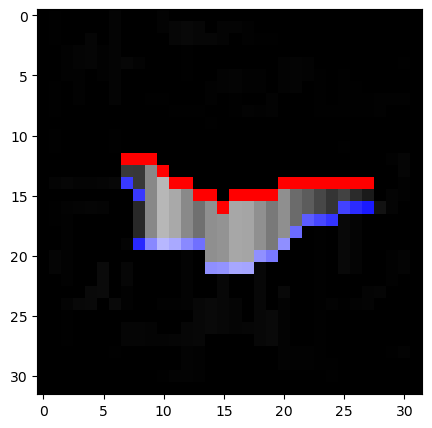

In [31]:
for j, (img, pt_label, pesudo_label) in enumerate(train_data_loader):
    B, _, H, W = img.shape
    indices = torch.where(pt_label > 1e-4)

    for b, _, s1, s2 in zip(*indices):
        # 提取区域
        targets = []
        size = 32

        y1 = max(1, s1 - size // 2)
        x1 = max(1, s2 - size // 2)
        y2 = min(H-1, s1 + (size - size // 2))
        x2 = min(W-1, s2 + (size - size // 2))
        _region = img[b:b+1,:1, y1:y2, x1:x2]

        _target, _ = gradient_expand_one_size(_region, [0.5, 0.5, 0.5])
